In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from scipy.linalg import lstsq
import timeit
from scipy import linalg
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF




Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
#to Run this you need to download the follwing files and locate them in the code dirctory:
#https://drive.google.com/file/d/1ubvNbmcf9I6rUfksey4oJAZ66Jd-rcM2/view?usp=sharing
#https://drive.google.com/file/d/1FMI6bnzDydZ1pfMmBYg10fJQ2ffryZgD/view?usp=sharing

In [2]:
#evalute the model fucntion- MSE
def compute_mean_and_std_test (y_predicted, y_observed):
    MSE = mean_squared_error(y_predicted, y_observed)
    #pearson = pearsonr(np.array(y_predicted).reshape((-1,)), np.array(y_observed).reshape((-1,)))
    #r2 = r2_score(y_predicted, y_observed)
    #MAE = mean_absolute_error(y_predicted, y_observed)
#     print("pearson:",pearson)
#     print("R2:",r2)
    print("MSE:",MSE)
#     print("MAE:",MAE)   

    return MSE

In [ ]:
#compute the matrix rank and the its condition number
def matrix_rank_and_condition_number (M, tol=None, hermitian=False):
    M = np.asarray(M)
    if M.ndim < 2:
        return int(not np.all(M==0))
    S = np.linalg.svd(M, compute_uv=False, hermitian=hermitian)
    if tol is None:
        tol = S.max(axis=-1, keepdims=True) * np.max(M.shape[-2:]) * np.finfo(S.dtype).eps
    else:
        tol = np.asarray(tol)[..., newaxis]
    return np.count_nonzero(S > tol, axis=-1), S[0]/S[-1]

In [3]:
# Define randomized SVD function
def rSVD(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.randn(ny,r+p)
    Z = X @ P
    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced')

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y,full_matrices=0)
    U = Q @ UY

    return U, S, VT

In [4]:
#diffrent types of LS solvers 
def ls_qr(A, b):
    q, r = linalg.qr(A, mode='economic')
    _, n = r.shape
    X = np.linalg.solve(r, q.T @ b)
    return X

def ls_cholesky(A, b):
    XT_X = A.T @ A
    XT_b = A.T @ b
    c, low = linalg.cho_factor(XT_X)
    X = linalg.cho_solve((c, low), XT_b)
    return X

def ls_given_reduced_Truncated_SVD (u, s, b):
    u_T = u.T
    s_inv = 1/s
    X = np.diag(s_inv) @ (u_T @ b)
    return X

def ls_given_SVD (u, s, v_T, b):
    u_T = u.T
    v = v_T.T
    s_inv = 1/s
    X = v @ ( np.diag(s_inv) @ (u_T @ b))
    return X
def ls_using_pesudo_inverse  (A, b):
    A_T_A_inv = linalg.inv (A.T @ A)
    X = A_T_A_inv @ (A.T @ b)
    return X

In [5]:
#apply the certain model type 
def train_and_test_model (X_train, X_test, y_train, y_test, model_type, u=None, s=None ,vh=None):
    mdl, predicted_y_train, predicted_y_test = None, None, None
    start, stop = None, None
    if (model_type == "linear_regression"):
        start = timeit.default_timer()
        mdl = LinearRegression().fit(X_train, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start) 
        predicted_y_test = mdl.predict(X_test)
        predicted_y_train = mdl.predict(X_train)
    elif (model_type == 'lasso_regression'):
        start = timeit.default_timer()
        mdl = Lasso(alpha=0.0001, max_iter=1000)
        mdl.fit(X_train, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start) 
        predicted_y_test = mdl.predict(X_test)
        predicted_y_train = mdl.predict(X_train)
    elif (model_type == 'LS_regression'):
        X_train_new = np.concatenate((X_train, np.full((X_train.shape[0], 1), 1)), axis=1)
        start = timeit.default_timer()
        p, res, rnk, s = lstsq(X_train_new, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        X_test_new = np.concatenate((X_test, np.full((X_test.shape[0], 1), 1)), axis=1)
        predicted_y_test = np.matmul(X_test_new, p)
        predicted_y_train = np.matmul(X_train_new, p)
    elif (model_type == 'LS'):
        start = timeit.default_timer()
        p, res, rnk, s = lstsq(X_train, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        predicted_y_test = np.matmul(X_test, p)
        predicted_y_train = np.matmul(X_train, p)
    elif(model_type == 'LS_QR'):
        start = timeit.default_timer()
        p = ls_qr(X_train, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)                
        predicted_y_test = np.matmul(X_test, p)
        predicted_y_train = np.matmul(X_train, p)
    elif(model_type == 'LS_cholesky'):
        start = timeit.default_timer()
        p = ls_cholesky(X_train, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        predicted_y_test = np.matmul(X_test, p)
        predicted_y_train = np.matmul(X_train, p)
    elif(model_type == "LS_given_reduced_Truncated_SVD"):
        start = timeit.default_timer()
        p = ls_given_reduced_Truncated_SVD (u, s, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        predicted_y_test = X_test @ p
        predicted_y_train = X_train @ p
    elif (model_type == "LS_given_SVD"):
        start = timeit.default_timer()
        p = ls_given_SVD (u, s, vh, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        predicted_y_test = X_test @ p
        predicted_y_train = X_train @ p
    elif (model_type == "LS_using_pesudo_inverse"):
        start = timeit.default_timer()
        p = ls_using_pesudo_inverse (X_train, y_train)
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        predicted_y_test = X_test @ p
        predicted_y_train = X_train @ p
    elif (model_type == "LS_RRQR"):
        start = timeit.default_timer()
        p, res, rnk, s = lstsq(X_train, y_train, lapack_driver='gelsy')
        stop = timeit.default_timer()
        print(model_type+' Time: ', stop - start)
        predicted_y_test = np.matmul(X_test, p)
        predicted_y_train = np.matmul(X_train, p)

        
    print("test")
    test_reaults = compute_mean_and_std_test (predicted_y_test, y_test)
    print("train")
    train_reaults = compute_mean_and_std_test (predicted_y_train, y_train)
    return test_reaults, train_reaults, stop - start

In [6]:
seq_PATH = "1-s2.0-S1097276517308730-mmc2.xlsx"
normalized_levels_PATH = "1-s2.0-S1097276517308730-mmc3.xlsx"

In [19]:
filename = 'features_1-7kmers.sav'
Fetures = pickle.load(open(filename, 'rb'))
features = Fetures.toarray()
del Fetures
y = np.matrix(pd.read_excel (A_minus_normalized_levels_PATH)) [1:,1:].astype('float32')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.22, random_state=31)
y_train_without_y0 = y_train[:,1:]
y_test_without_y0 = y_test[:,1:]

In [9]:
def svd_iterations (X_train, X_test, y_train, y_test, ranks, X_with_y0_OR_without):
    y_train_without_y0 = y_train[:,1:]
    y_test_without_y0 = y_test[:,1:]
    if(X_with_y0_OR_without == "X_with_y0"):
        X_train = np.concatenate((X_train, y_train[:,0]), axis=1)
        X_test = np.concatenate((X_test, y_test[:,0]), axis=1)

    
    u, s, vh = np.linalg.svd(X_train, full_matrices=False)
    v = vh.T
    
    
    solutions_types = ["LS_cholesky", "LS_QR", "LS_RRQR", "LS", "LS_using_pesudo_inverse"]
    results_dict ={"LS_cholesky": {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS_QR" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS_RRQR": {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS_using_pesudo_inverse" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "condition_number" : []
                   }
    if(X_with_y0_OR_without == "X_with_y0"):
        solutions_types = solutions_types+["LS_given_reduced_Truncated_SVD", "LS_given_SVD"]
        results_dict.update( {"LS_given_reduced_Truncated_SVD" : {"test_reaults": [], "train_reaults": [], "time": []},
                          "LS_given_SVD" : {"test_reaults": [], "train_reaults": [], "time": []}}
                       )
    
    for r in ranks:
        print("rank: ",r)
        #compute the reduced matrix
        u_r = u[:,:r]
        s_r = s[:r]
        v_r = v[:,:r]
        results_dict ["condition_number"].append(s_r[0]/s_r[r-1])
        X_train_svd_r = u_r @ np.diag(s_r)
        X_test_svd_r = X_test @ v_r
        
        if (X_with_y0_OR_without == "X_without_y0"):
            X_train_svd_r = np.concatenate((X_train_svd_r, y_train[:,0]), axis=1)
            X_test_svd_r = np.concatenate((X_test_svd_r, y_test[:,0]), axis=1)
         #solve for the different types of solvers  
        for solutions_type in solutions_types:
            if(solutions_type != "LS_given_SVD"):
                test_reaults, train_reaults, time = train_and_test_model (X_train_svd_r, X_test_svd_r, y_train_without_y0, y_test_without_y0, solutions_type, u_r, s_r, v_r.T)
            else:
                test_reaults, train_reaults, time = train_and_test_model (X_train, X_test, y_train_without_y0, y_test_without_y0, solutions_type, u_r, s_r, v_r.T)   
            results_dict[solutions_type]["test_reaults"].append(test_reaults)
            results_dict[solutions_type]["train_reaults"].append(train_reaults)
            results_dict[solutions_type]["time"].append(time)
            
    return results_dict

In [10]:
def randomized_svd_iterations (X_train, X_test, y_train, y_test, ranks, X_with_y0_OR_without):
    y_train_without_y0 = y_train[:,1:]
    y_test_without_y0 = y_test[:,1:]
    
    if(X_with_y0_OR_without == "X_with_y0"):
        X_train = np.concatenate((X_train, y_train[:,0]), axis=1)
        X_test = np.concatenate((X_test, y_test[:,0]), axis=1)
    
    solutions_types = ["LS_cholesky", "LS_QR", "LS_RRQR", "LS", "LS_using_pesudo_inverse"]
    results_dict ={"LS_cholesky": {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS_QR" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS_RRQR": {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS_using_pesudo_inverse" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "condition_number" : [],
                   "Ramdomized_SVD_time" : []
                   }
    if(X_with_y0_OR_without == "X_with_y0"):
        solutions_types = solutions_types+["LS_given_reduced_Truncated_SVD", "LS_given_SVD"]
        results_dict.update( {"LS_given_reduced_Truncated_SVD" : {"test_reaults": [], "train_reaults": [], "time": []},
                          "LS_given_SVD" : {"test_reaults": [], "train_reaults": [], "time": []}}
                       )
    
    for r in ranks:
        print("rank: ",r)
        #compute the reduced matrix
        start = timeit.default_timer()
        p, q = 10, 1
        u, s, vh = rSVD(X_train, r, q, p)
        u_r = u[:,:-p]
        s_r = s[:-p]
        v_r = vh.T[:,:-p]
        stop = timeit.default_timer()
        print(u_r.shape)
        print('randomized Time: ', stop - start)
        results_dict["Ramdomized_SVD_time"].append(stop - start)
        results_dict ["condition_number"].append(s_r[0]/s_r[r-1])
        X_train_svd_r = u_r @ np.diag(s_r)
        X_test_svd_r = X_test @ v_r
        
        if (X_with_y0_OR_without == "X_without_y0"):
            X_train_svd_r = np.concatenate((X_train_svd_r, y_train[:,0]), axis=1)
            X_test_svd_r = np.concatenate((X_test_svd_r, y_test[:,0]), axis=1)
         #solve for the different types of solvers  
        for solutions_type in solutions_types:
            if(solutions_type != "LS_given_SVD"):
                test_reaults, train_reaults, time = train_and_test_model (X_train_svd_r, X_test_svd_r, y_train_without_y0, y_test_without_y0, solutions_type, u_r, s_r, v_r.T)
            else:
                test_reaults, train_reaults, time = train_and_test_model (X_train, X_test, y_train_without_y0, y_test_without_y0, solutions_type, u_r, s_r, v_r.T)   
            results_dict[solutions_type]["test_reaults"].append(test_reaults)
            results_dict[solutions_type]["train_reaults"].append(train_reaults)
            results_dict[solutions_type]["time"].append(time)
            
    return results_dict

In [11]:
def NMF_iterations (X_train, X_test, y_train, y_test, ranks):
    y_train_without_y0 = y_train[:,1:]
    y_test_without_y0 = y_test[:,1:]
    
    solutions_types = ["LS_RRQR", "LS"] #can't solve with cholesky because it's not positive definie, and can't solve using QR and pesudo inverse as the matrix is singular 
    results_dict ={"LS_RRQR": {"test_reaults": [], "train_reaults": [], "time": []},
                   "LS" : {"test_reaults": [], "train_reaults": [], "time": []},
                   "condition_number" : [],
                   "computed_rank" : [],
                   "NMF_time" : []
                   }
    
    for r in ranks:
        print("rank: ",r)
        #compute the reduced matrix
        start = timeit.default_timer()
        model = NMF(n_components=r, init='random', random_state=0)
        X_train_NMF = model.fit_transform(X_train)
        stop = timeit.default_timer()
        print('NMF Time: ', stop - start)
        results_dict["NMF_time"].append(stop - start)
        start = timeit.default_timer()
        computed_rank, condition_number = matrix_rank_and_condition_number (X_train_NMF, tol=None, hermitian=False)
        stop = timeit.default_timer()
        print('condition_number and rank compute Time: ', stop - start)
        #condition_number = np.linalg.cond(X_train_NMF) 
        results_dict ["condition_number"].append(condition_number)
        results_dict ["computed_rank"].append(computed_rank)
        print("condition_number: ", condition_number)
        print("computed_rank:", computed_rank)
        X_test_NMF = model.transform(X_test)
        
        X_train_NMF_with_y0 = np.concatenate((X_train_NMF, y_train[:,0]), axis=1)
        X_test_NMFa_with_y0 = np.concatenate((X_test_NMF, y_test[:,0]), axis=1)
        
         #solve for the different types of solvers  
        for solutions_type in solutions_types:
            test_reaults, train_reaults, time = train_and_test_model (X_train_NMF_with_y0, X_test_NMFa_with_y0, y_train_without_y0, y_test_without_y0, solutions_type)
            results_dict[solutions_type]["test_reaults"].append(test_reaults)
            results_dict[solutions_type]["train_reaults"].append(train_reaults)
            results_dict[solutions_type]["time"].append(time)
            
    return results_dict

In [ ]:
ranks_SVD = []
for i in range(1,10):
    ranks_SVD.append(i*10)
for i in range(1,31):
    ranks_SVD.append(i*100)
for i in range (1,11):
    ranks_SVD.append(3000+i*300)
for i in range(1,8):
    ranks_SVD.append(6000+i*500)
for i in range(1,12):
    ranks_SVD.append(9500+i*1000)
ranks_SVD.append(21845)
results_dict_truncate_full_SVD_X_with_y0 = svd_iterations(X_train, X_test, y_train, y_test, ranks_SVD, X_with_y0_OR_without="X_with_y0")

In [ ]:
ranks_randomized = []
for i in range(1,10):
    ranks_randomized.append(i*10)
for i in range(1,31):
    ranks_randomized.append(i*100)

ranks_randomized = ranks_randomized + [5100, 7000, 11500, 16500, 19500, 20500]
ranks_randomized = ranks_randomized + [21845]
results_dict_randomized = randomized_svd_iterations(X_train, X_test, y_train, y_test, ranks_randomized, X_with_y0_OR_without="X_with_y0")

In [ ]:
ranks_NMF = [10,100, 200, 400, 600, 800, 1000, 1200, 1400]
results_dict_NMF = NMF_iterations(X_train, X_test, y_train, y_test, ranks_NMF)

In [ ]:
X_train_with_y0 = np.concatenate((X_train, y_train[:,0]), axis=1)
X_test_with_y0 = np.concatenate((X_test, y_test[:,0]), axis=1)

     
u, s, vh = np.linalg.svd(X_train_with_y0, full_matrices=False)

solutions_types = ["LS_QR", "LS_RRQR", "LS", "LS_given_SVD", "LS_using_pesudo_inverse"]
results_dict_full_sized_problem = {"LS_QR" : {"test_reaults": [], "train_reaults": [], "time": []},
                                   "LS_RRQR": {"test_reaults": [], "train_reaults": [], "time": []},
                                   "LS" : {"test_reaults": [], "train_reaults": [], "time": []},
                                   "LS_given_SVD" : {"test_reaults": [], "train_reaults": [], "time": []},
                                   "LS_using_pesudo_inverse" : {"test_reaults": [], "train_reaults": [], "time": []}
                                   }
for solutions_type in solutions_types:
    test_reaults, train_reaults, time = train_and_test_model (X_train_with_y0, X_test_with_y0, y_train_without_y0, y_test_without_y0, solutions_type, u, s, vh)   
    results_dict_full_sized_problem[solutions_type]["test_reaults"].append(test_reaults)
    results_dict_full_sized_problem[solutions_type]["train_reaults"].append(train_reaults)
    results_dict_full_sized_problem[solutions_type]["time"].append(time)

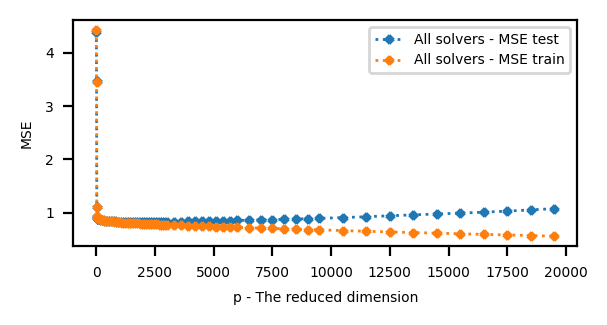

In [83]:
fig=plt.figure(figsize=(3.25, 1.5), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(ranks_SVD[:-2],
         results_dict_truncate_full_SVD_X_with_y0["LS_cholesky"]["test_reaults"][:-2],
           ':X', markersize=2, linewidth=1, label='All solvers - MSE test')


plt.plot(ranks_SVD[:-2],
         results_dict_truncate_full_SVD_X_with_y0["LS_cholesky"]["train_reaults"][:-2],
           ':X', markersize=2, linewidth=1, label='All solvers - MSE train')


plt.tick_params(axis='both', which='major', labelsize=5)
plt.tick_params(axis='both', which='minor', labelsize=5)
plt.legend( fontsize=5)
plt.xlabel("p - The reduced dimension", fontsize=5)
plt.ylabel("MSE", fontsize=5)
plt.savefig("SVD_MSE_with_y0_plot.png", dpi=200, bbox_inches = "tight")
plt.show()




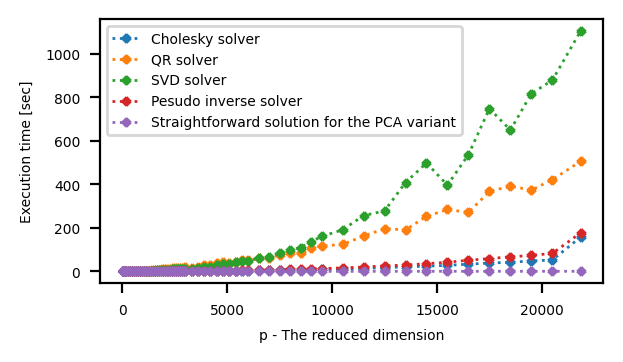

In [84]:
"LS_cholesky", "LS_QR", "LS_RRQR", "LS", "LS_using_pesudo_inverse"
"LS_given_reduced_Truncated_SVD", "LS_given_SVD"
fig=plt.figure(figsize=(3.25, 1.75), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(ranks_SVD,
         results_dict_truncate_full_SVD_X_with_y0["LS_cholesky"]["time"],
           ':X',  markersize=2, linewidth=1, label='Cholesky solver')
plt.plot(ranks_SVD,
         results_dict_truncate_full_SVD_X_with_y0["LS_QR"]["time"],
           ':X',  markersize=2, linewidth=1, label='QR solver')
plt.plot(ranks_SVD,
         results_dict_truncate_full_SVD_X_with_y0["LS"]["time"],
           ':X',  markersize=2, linewidth=1, label='SVD solver')
plt.plot(ranks_SVD,
         results_dict_truncate_full_SVD_X_with_y0["LS_using_pesudo_inverse"]["time"],
           ':X',  markersize=2, linewidth=1, label='Pesudo inverse solver')
plt.plot(ranks_SVD,
         results_dict_truncate_full_SVD_X_with_y0["LS_given_reduced_Truncated_SVD"]["time"],
           ':X',  markersize=2, linewidth=1, label='Straightforward solution for the PCA variant')

plt.tick_params(axis='both', which='major', labelsize=5)
plt.tick_params(axis='both', which='minor', labelsize=5)
plt.legend( fontsize=5)
plt.xlabel("p - The reduced dimension", fontsize=5)
plt.ylabel("Execution time [sec]", fontsize=5)
plt.savefig("SVD_TIME_with_y0_plot.png", dpi= 200, bbox_inches = "tight")
plt.show()

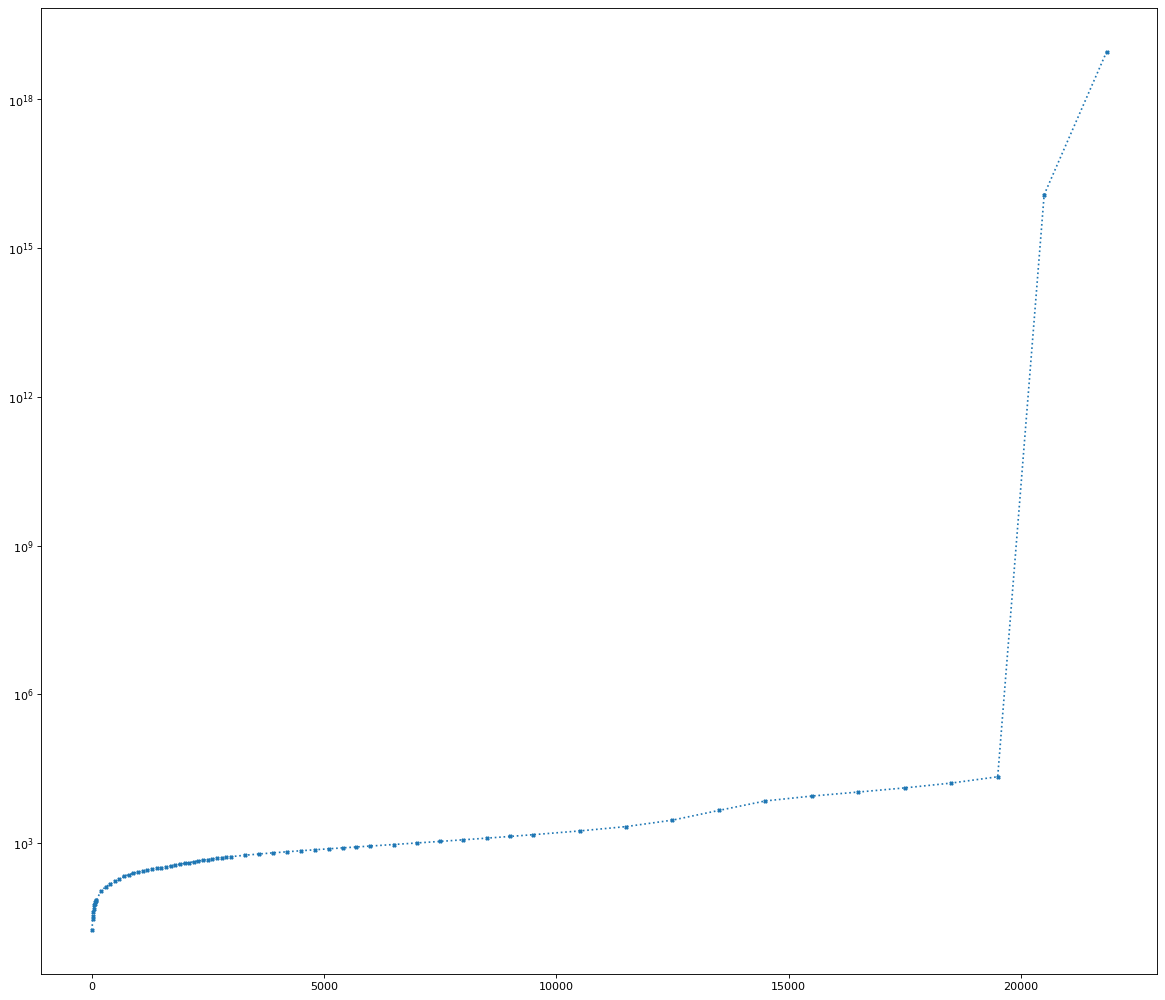

In [15]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ranks_SVD,
         results_dict_truncate_full_SVD_X_with_y0["condition_number"],
           ':X', markersize=3, label='condition_number')

plt.yscale("log")
plt.show()

In [79]:
results_tests = results_dict_NMF["LS"]["test_reaults"]
results_train = results_dict_NMF["LS"]["train_reaults"]
NMF_time = results_dict_NMF["NMF_time"]
NMF_time_in_houres = [x/3600 for x in NMF_time]

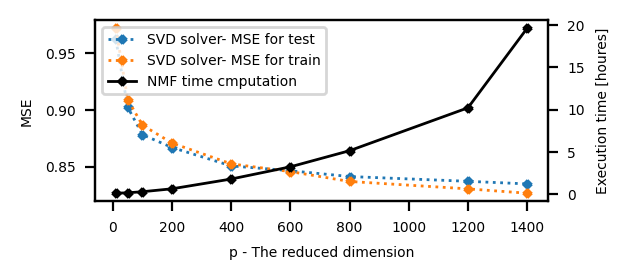

In [80]:
fig = plt.figure(figsize=(3.25, 1.5), dpi= 200, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax2 = ax.twinx()


l1,  = ax.plot(ranks_NMF,
         results_tests,
           ':X', markersize=2, linewidth=1, label='SVD solver- MSE for test')
l2, = ax.plot(ranks_NMF,
         results_train,
           ':X', markersize=2, linewidth=1, label='SVD solver- MSE for train')
l3, = ax2.plot(ranks_NMF,
         NMF_time_in_houres, 
           '-X', color='black', markersize=2, linewidth=1, label='NMF time cmputation')

ax2.legend(handles=[l1, l2, l3], fontsize=5)

ax.set_xlabel("p - The reduced dimension", fontsize=5)
ax.set_ylabel("MSE", fontsize=5)
ax2.set_ylabel("Execution time [houres]", fontsize=5)
ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=5)
ax2.tick_params(axis='both', which='major', labelsize=5)
ax2.tick_params(axis='both', which='minor', labelsize=5)
plt.tight_layout()
plt.savefig("NMF_plot.png", dpi= 200)
plt.show()

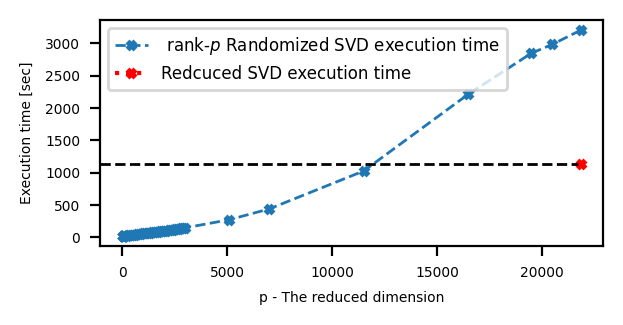

In [76]:
fig=plt.figure(figsize=(3.25, 1.5), dpi= 200, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.plot(ranks_randomized,
         results_dict_randomized["Ramdomized_SVD_time"]+[3200],
           '--X',  markersize=3, linewidth=1, label=' rank-$p$ Randomized SVD execution time')

plt.plot(21845, 1140, ':X',  markersize=3, color="red", label='Redcuced SVD execution time')
plt.axhline(y=1140,xmax=0.95, color='black', linestyle="--", linewidth=1)

plt.tick_params(axis='both', which='major', labelsize=5)
plt.tick_params(axis='both', which='minor', labelsize=5)
plt.xlabel("p - The reduced dimension", fontsize=5)
plt.ylabel("Execution time [sec]", fontsize=5)

plt.legend( fontsize=6)
plt.savefig("Randomized_SVD_time.png", dpi= 200, bbox_inches = "tight")
plt.show()

In [68]:
with open(r"Xtain_with_y0_SVD_full.sav", "rb") as input_file:
    [u, s, vh] = pickle.load(input_file)

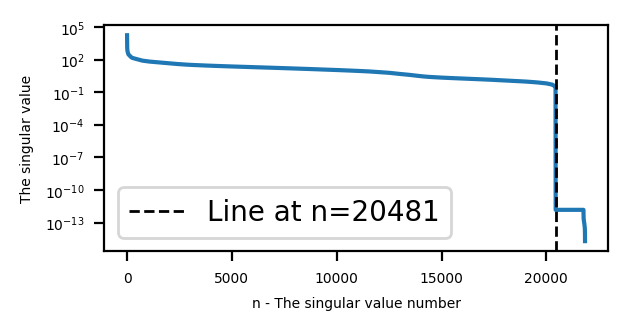

In [73]:
fig=plt.figure(figsize=(3.25, 1.5), dpi= 200, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.semilogy(s)
plt.axvline(x=20481, color='black', linestyle="--", linewidth=1, label='Line at n=20481')
plt.xlabel("n - The singular value number", fontsize=5)
plt.ylabel("The singular value", fontsize=5)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.tick_params(axis='both', which='minor', labelsize=5)
plt.legend()
plt.savefig("singular_values_with_y0.png",  dpi= 200, bbox_inches = "tight")
plt.show()